In [21]:
import numpy as np
import torch
import torch.nn as nn
import time 
import logging
import torch.optim as optim
import os
from scipy.stats import multivariate_normal as normal
import torch.nn.functional as F
from torch.nn import Parameter
import matplotlib.pyplot as plt

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

data_type=torch.float32
MOMENTUM = 0.99
EPSILON = 1e-6

Using cpu device


In [34]:
class Config(object):
    n_layer = 4
    batch_size = 1024
    valid_size = 1024
    
    dim=100; 
    Ntime=10; 
    delta=1/Ntime
    sqrt_deltaT=np.sqrt(1.0/Ntime); 
    lam=1; 

    logging_frequency = 100
    verbose = True
    y_init_range = [0, 1]
    
    num_hiddens = [dim,128,128,dim] ## 256 ,256
    
def get_config(name):
    try:
        return globals()[name]
    except KeyError:
        raise KeyError("config not defined.")

In [35]:
cfg=get_config('Config')

In [36]:
"""
This function defines one block for the nn 
"""
class Dense(nn.Module): 
    def __init__(self,cin, cout, batch_norm=False, activate=True): 
        super(Dense,self).__init__()
        self.cin=cin; 
        self.cout=cout; 
        self.activate=activate; 
        
        self.linear=nn.Linear(self.cin,self.cout) #The linear layer
        #BatchNorm1d: it requires the input to be a correct size
        if batch_norm: 
            self.bn=nn.BatchNorm1d(cout,eps=EPSILON,momentum=MOMENTUM)
        else: 
            self.bn=None
      #  nn.init.normal_(self.linear.weight,std=5.0/np.sqrt(cin+cout))
        # This is the He initialization
        
    def forward(self,x): 
        x=self.linear(x)
        if self.bn is not None:
            x=self.bn(x)
        if self.activate:
            x=torch.sin(x)
        return x 

In [37]:
#orch.LeakyReLU

In [38]:
"""
Constructing the Policy control

The control should take as input (X')=(t,X) as the input, and so the input dimension 
should be 1+dim
"""
class controlNN(nn.Module):
    def __init__(self, config):
        super(controlNN,self).__init__()
        self.config=config
        
        self.bn=nn.BatchNorm1d(config.num_hiddens[0],eps=EPSILON,momentum=MOMENTUM) ## So there is batch norm no problem
        # range(1,5): 1,2,3,4
        self.layers=[Dense(config.num_hiddens[i-1],config.num_hiddens[i]) for i in range(1, len(config.num_hiddens)-1)]
        self.layers+=[Dense(config.num_hiddens[-2], config.num_hiddens[-1],activate=False)]
        self.layers=nn.Sequential(*self.layers)
    
    def forward(self,x):
        x=self.bn(x)
        x=self.layers(x)
        return x 

In [39]:
class NeuralNet(nn.Module):
    def __init__(self,config):
        super(NeuralNet, self).__init__()
        self.config=config
        self.batch_size=self.config.batch_size
        self.dim=self.config.dim
        self.Ntime=self.config.Ntime
        self.delta=self.config.delta
        self.sqrt_deltaT =self.config.sqrt_deltaT
        self.diffusion=torch.sqrt(2.0*torch.ones(1))
        self.diffusion.requires_grad=False
        self.lam=self.config.lam
        
        ## We make the change here 
        self.mList=nn.ModuleList([controlNN(config) for _ in range(self.Ntime)])    # controlNN(self.config)
        
        self.time_stamp=torch.ones([self.batch_size,1, self.Ntime+1])*torch.arange(0,self.Ntime+1)*self.delta
        
        # x should have the size (batch_size,_)
        
    def g(self,x):
        temp=torch.log(0.5*(1.0+ torch.sum(torch.square(x), dim=1, keepdim=True))) 
        return temp
    
    def gx(self,x):
        temp= x*2.0/(1.0+torch.sum(torch.square(x), dim=1, keepdim=True))
        return temp
        
        
    def forwardX(self,x): 
        xMat=torch.zeros([self.batch_size, self.dim, self.Ntime+1])
       # xcatMat=torch.zeros([self.batch_size, self.dim+1, self.Ntime+1])
        
        wMat=torch.FloatTensor(normal.rvs(size=[self.batch_size,self.dim,self.Ntime])*self.sqrt_deltaT)
        wMat=torch.reshape(wMat,(self.batch_size,self.dim,self.Ntime)) # Reshaping is needed when dim==1 
        
        xinit=torch.clone(x)
        xinit=torch.reshape(xinit,[self.batch_size, self.dim])
        
        xMat[:,:,0]=xinit 
        
       # xcat=torch.cat((self.time_stamp[:,:,0], xMat[:,:,0]),1)
        for i in range(0, self.Ntime):
          #  xcat=torch.cat((self.time_stamp[:,:,i], xMat[:,:,i]),1)
        #    xcatMat[:,:,i]= xcat

            control_temp=self.mList[i](xMat[:,:,i]); 

            xMat[:,:,i+1]=xMat[:,:,i]+(2.0*np.sqrt(self.lam)*control_temp)*self.delta \
            +self.diffusion*wMat[:,:,i]  
        
        return xMat, wMat 
        
    def backwardYZ(self,xMat,wMat): 
        yMat=torch.zeros([self.batch_size, self.dim, self.Ntime+1]); 
        zMat=torch.zeros([self.batch_size, self.dim, self.Ntime]);
        
        yMat[:,:,-1]=-1.0*self.gx(xMat[:,:,-1]); 
        
        for i in range(self.Ntime-1, -1, -1):
            zMat[:,:,i]= wMat[:,:,i]*yMat[:,:,i+1]/self.delta
            # we will have to do the differentiation and everything
            
            X=xMat[:,:,i];
          #  xcat=torch.cat((self.time_stamp[:,:,i],X),1)   
            # y*b+σ*z+f
            
            ctrl=self.mList[i](X)
            
            hami=torch.sum(np.sqrt(self.lam)*2.0*yMat[:,:,i+1].detach()*ctrl  
                           +self.diffusion*zMat[:,:,i].detach() - ctrl*ctrl,
                           dim=1, keepdim=True)
            
            hami_x=torch.autograd.grad(outputs=[hami], inputs=[X], grad_outputs=torch.ones_like(hami), allow_unused=True,
                                 retain_graph=True, create_graph=True)[0]
            
            yMat[:,:,i]= yMat[:,:,i+1] +hami_x* self.delta 
            
        return yMat, zMat
    
    def Hamcompute(self,xMat,yMat,zMat):
        ham=0.0
        for i in range(0,self.Ntime):
         #   xcat=torch.cat((self.time_stamp[:,:,i],xMat[:,:,i]),1); 
            X=xMat[:,:,i]
            temp=self.mList[i](X.detach()); 

            ham+=ham+torch.sum(np.sqrt(self.lam)*2.0*yMat[:,:,i].detach()* temp
                           +self.diffusion*zMat[:,:,i].detach() - temp*temp)
        return -ham/self.batch_size/self.Ntime

    def computeLoss(self,xMat):
        loss=0.0 
        for i in range(0,self.Ntime):
            #xcat=torch.cat((self.time_stamp[:,:,i],xMat[:,:,i]),1)
            X=xMat[:,:,i]
            tempctrl=self.mList[i](X)
            
            loss+=torch.sum(torch.square(tempctrl),dim=1,keepdim=True)*self.delta
        
        loss+=self.g(xMat[:,:,-1])
        
        return torch.mean(loss) 

In [40]:
def train(cfg):
    
    model=NeuralNet(cfg);
    x0=torch.zeros([cfg.batch_size,cfg.dim])
    
    epoch=400; 
    
    optimizer=optim.Adam(model.parameters(),lr=1e-3)
    
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[400], gamma=0.1) 
    
    
    for i in range(0, epoch):
        optimizer.zero_grad()
        
        xmat,wmat=model.forwardX(x0)
        ymat,zmat=model.backwardYZ(xmat,wmat)
        # compute the Hamiltonian
        ham=model.Hamcompute(xmat,ymat,zmat)
        ham.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(),10)
        
        optimizer.step()
       # scheduler.step()
        
        if i % 20 ==0:           
            print("Iter:", i,  model.computeLoss(xmat).item())

In [41]:
md=NeuralNet(cfg)

In [42]:
train(cfg) #torch.mean(ymat[:,:,0]).item(),

Iter: 0 5.251187324523926
Iter: 20 4.604968547821045
Iter: 40 4.596710205078125
Iter: 60 4.586008071899414
Iter: 80 4.59016227722168
Iter: 100 4.588786602020264
Iter: 120 4.5910139083862305
Iter: 140 4.5925469398498535
Iter: 160 4.584819316864014
Iter: 180 4.593784332275391
Iter: 200 4.590529441833496
Iter: 220 4.595129013061523
Iter: 240 4.595467567443848
Iter: 260 4.592103958129883
Iter: 280 4.592272758483887
Iter: 300 4.579254150390625
Iter: 320 4.5872297286987305
Iter: 340 4.592634201049805
Iter: 360 4.59251594543457
Iter: 380 4.589260578155518


In [59]:
def gTerm(x):
    temp=torch.log(0.5*(1.0+ torch.sum(torch.square(x), dim=1, keepdim=True))) 
    return temp

In [80]:
def gExt(x,lamb):
    res=-1.0/lamb * torch.log(torch.mean( torch.exp(-gTerm(np.sqrt(2.0)*x))**lamb ))   
    return res

In [129]:
dim_in=100
Xin=torch.FloatTensor(normal.rvs(size=[100000,dim_in]))
gExt(Xin,15*torch.ones(1))

tensor([4.4340])

In [136]:
vec=[1.0,5.0,10.0,15.0,20.0]
pred=[4.5897,4.5545,4.50,4.44,4.393]
exactVal=[4.59,4.5478,4.4959,4.433,4.3735]

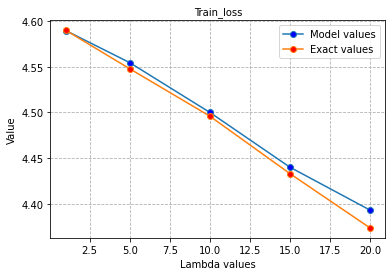

In [143]:
fig = plt.figure(facecolor=(1, 1, 1))
plt.grid(True,which="both", linestyle='--')

plt.plot(vec,pred,linestyle='-', marker='o',
     markerfacecolor='blue')
plt.plot(vec,exactVal,linestyle='-', marker='o',
     markerfacecolor='red')
plt.ylabel('Value')
plt.xlabel('Lambda values')
plt.title('Train_loss', fontsize=10)

plt.legend(["Model values", "Exact values"])

#plt.savefig("hjb.png",bbox_inches='tight')